# code to demo where we have known spikes and bad channels to apply to ECoG TBI data

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from py_ecog_utils import line_length, bipolar_select

#
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib import colormaps
%matplotlib widget

# import mne
import mne

# import FOOOF

from fooof import FOOOF

# use neurodsp toolbox to generate signal and plot

from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed,create_times

# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw, compute_spectral_hist

# import sliding window functions

from neurodsp.rhythm import sliding_window_matching

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra, plot_spectral_hist
from neurodsp.filt import filter_signal
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.rhythm import plot_swm_pattern
from neurodsp.plts.time_series import plot_time_series, plot_bursts, plot_multi_time_series

/Users/davidcaldwell/.pyenv/versions/mne_3_12/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [9]:
data_base_path = '/Users/davidcaldwell/Data/seahorse_data/an/preprocessed'
data_specific = '/EC129/EC129_B9'
data_dict= scipy.io.loadmat(data_base_path + data_specific + '/MAT files/EC129_B9_notched.mat')
bad_channels = scipy.io.loadmat(data_base_path + data_specific + '/EC129_B9_badch.mat')

In [10]:
sfx = data_dict['sfx'].item()
data_int = data_dict['d']
ch_names = [str(i) for i in range(data_int.shape[1])]
info = mne.create_info(ch_names=ch_names, sfreq=sfx, ch_types='ecog')
raw = mne.io.RawArray(data_int.T, info)
data_ll = line_length.line_length_transform(data_int, sfx=sfx,llw=0.04,badch=bad_channels)
raw_ll = mne.io.RawArray(data_ll.T, info)


Creating RawArray with float64 data, n_channels=330, n_times=190449
    Range : 0 ... 190448 =      0.000 ...   371.969 secs
Ready.
Creating RawArray with float64 data, n_channels=330, n_times=190449
    Range : 0 ... 190448 =      0.000 ...   371.969 secs
Ready.


## Working on example bipolar re-referencing

In [11]:
# define bipolar channel list, make into function 
cathode_list, anode_list,distance_list = bipolar_select.generate_bipolar_pair_list(6,256,10)

raw_bip_ref = mne.set_bipolar_reference(raw, anode=anode_list,cathode=cathode_list)

select_list = bipolar_select.generate_select_list(anode_list, cathode_list, distance_list,distance_int=10)

data_int, time_vec =raw_bip_ref.get_data(select_list, return_times=True)


ECoG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=21, n_times=190449
    Range : 0 ... 190448 =      0.000 ...   371.969 secs
Ready.
Added the following bipolar channels:
256-257, 256-258, 256-259, 256-260, 256-261, 256-262, 257-258, 257-259, 257-260, 257-261, 257-262, 258-259, 258-260, 258-261, 258-262, 259-260, 259-261, 259-262, 260-261, 260-262, 261-262


In [12]:
# define bipolar channel of interest 

chan_int = 0

/Users/davidcaldwell/.pyenv/versions/mne_3_12/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/davidcaldwell/.pyenv/versions/mne_3_12/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/davidcaldwell/.pyenv/versions/mne_3_12/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


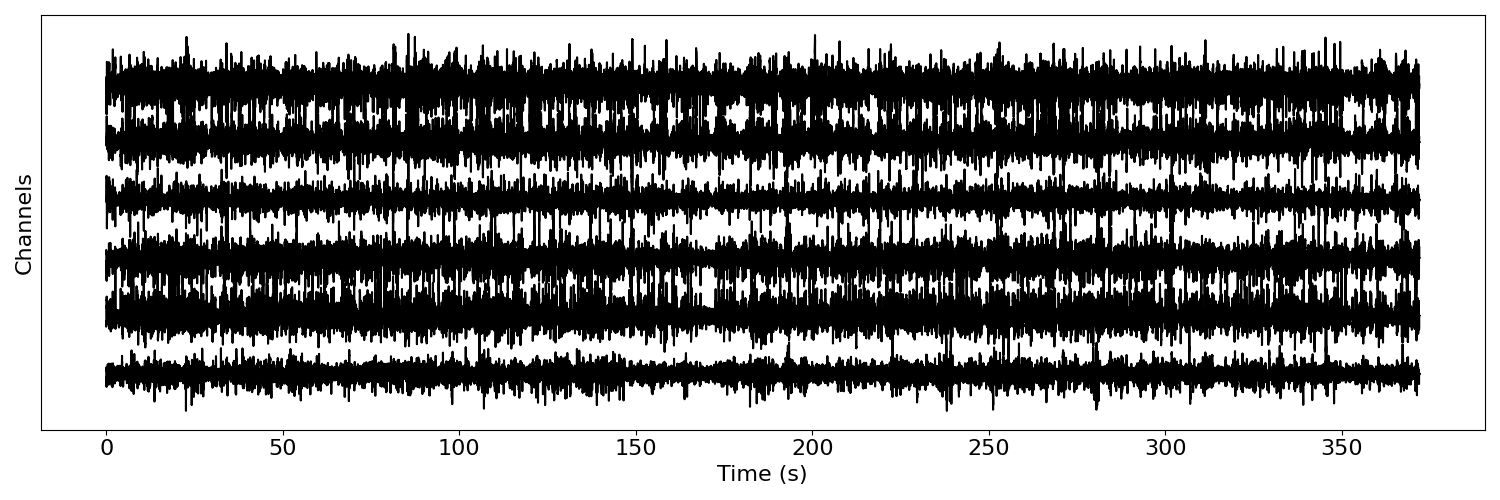

In [13]:
plot_multi_time_series(time_vec,data_int)

In [14]:
data_int_ll = line_length.line_length_transform(data_int,sfx=sfx,llw=0.04)


/Users/davidcaldwell/.pyenv/versions/mne_3_12/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


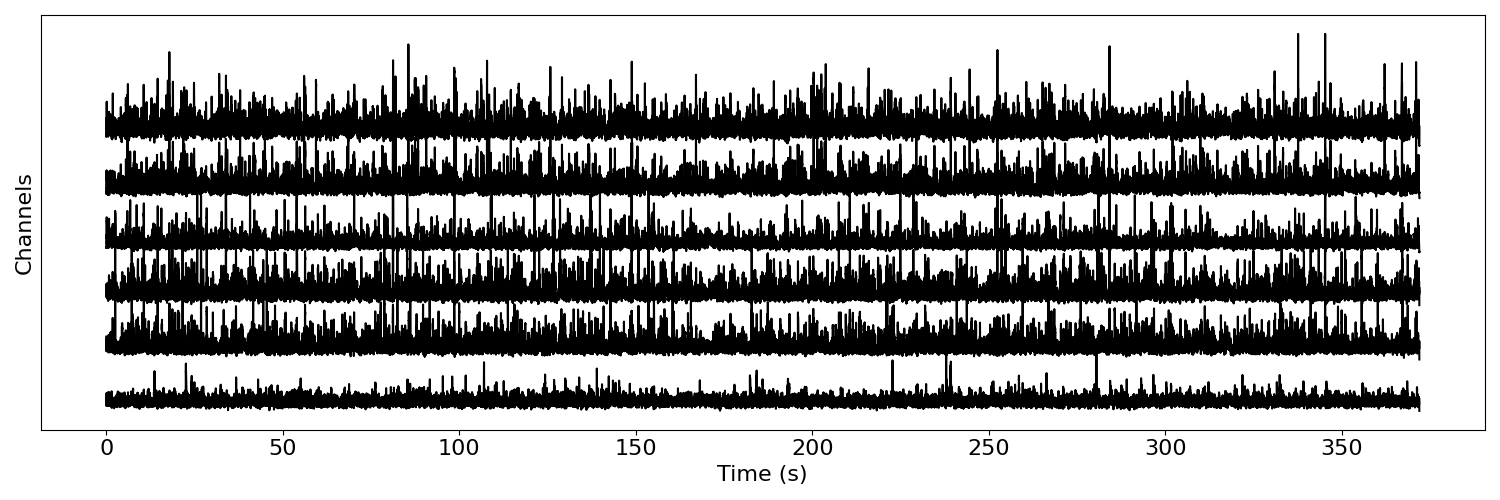

In [17]:
plot_multi_time_series(time_vec,data_int_ll.T)

In [18]:
# begin processing

# notch filter
#filter_range = (58,62)

#notch_data = filter_signal(data_int,sfx,'bandstop',filter_range,n_seconds=0.5)
freq_mean, psd_mean = compute_spectrum(data_int, sfx, method='welch', avg_type='mean', nperseg=sfx*2)


/Users/davidcaldwell/.pyenv/versions/mne_3_12/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


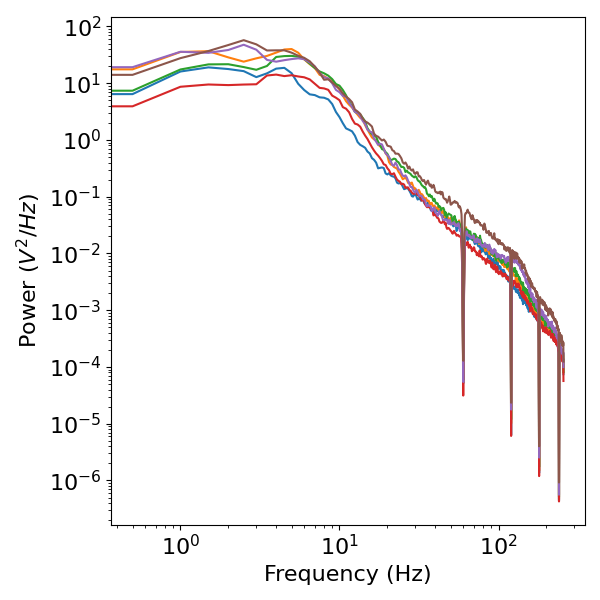

In [20]:
plot_power_spectra(freq_mean,psd_mean)


In [ ]:
# sliding window matching
# Define window length & minimum window spacing, both in seconds
win_len = .055
win_spacing = .055

# Apply the sliding window matching algorithm to the time series
windows, window_starts = sliding_window_matching(data_int[chan_int,:], sfx, win_len, win_spacing, var_thresh=.5)

# Compute the average window
avg_window = np.mean(windows, 0)

# Plot the discovered pattern
plot_swm_pattern(avg_window)

In [ ]:
# Calculate the spectral histogram
freqs, bins, spect_hist = compute_spectral_hist(notch_data[chan_int,:], sfx, nbins=50, f_range=(0, 80),
                                                cut_pct=(0.1, 99.9))

# Calculate a power spectrum, with median Welch
freq_med, psd_med = compute_spectrum(notch_data[chan_int,:], sfx, method='welch',
                                     avg_type='median', nperseg=sfx*2)

# Plot the spectral histogram
plot_spectral_hist(freqs, bins, spect_hist, freq_med, psd_med)

In [ ]:
# foof

fooof_total = []

# Define model settings
peak_width = [1, 8]             # `peak_width_limit` setting
n_peaks = 6                     # `max_n_peaks` setting
peak_height = 0.10              # `min_peak_height` setting

# Define frequency range
PSD_range = [30, 45]

# fooof over each channel 
for idx in list(range(0,psd_mean.shape[0])):
    # Initialize a model object for spectral parameterization, with some settings
    fm = FOOOF(peak_width_limits=peak_width, max_n_peaks=n_peaks, min_peak_height=peak_height, verbose=False)
    
    # Fit individual PSD over 3-40 Hz range
    fm.report(freq_mean, psd_mean[idx,:], PSD_range)

    #plt.savefig(f"fooof{idx}")
    
    # Access the model fit parameters from the model object
    print('Aperiodic parameters: \n', fm.aperiodic_params_, '\n')
    print('Peak parameters: \n', fm.peak_params_, '\n')
    print('Goodness of fit:')
    print('Error - ', fm.error_)
    print('R^2   - ', fm.r_squared_, '\n')
    print('Number of fit peaks: \n', fm.n_peaks_)
    
    fooof_output = fm
    fooof_total.append(fooof_output)

In [ ]:
### THINK ABOUT ICA TO LOOK AT ARTIFACTS?